#Computer vision Project - Direct Colourisation using Lab
### By Han Chenfeng and Ishita Gupta 


In [ ]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate, Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


LWIR: /content/drive/My Drive/Colab Notebooks/images 4/set01/V005/lwir

VISIBLE: /content/drive/My Drive/Colab Notebooks/images 4/set01/V005/visible/images/val/class

In [ ]:
# Get images
# Change to '/data/images/Train/' to use all the 10k images
X = []
for filename in os.listdir('/content/drive/My Drive/Colab Notebooks/images 4/set01/V005/visible/images/train/class/'):
    X.append(img_to_array(load_img('/content/drive/My Drive/Colab Notebooks/images 4/set01/V005/visible/images/train/class/'+filename)))
X = np.array(X, dtype=float)
XCtrain = 1.0/255*X


In [ ]:
X = []
for filename in os.listdir('/content/drive/My Drive/Colab Notebooks/images 4/set01/V005/lwir/images/train/class/'):
    X.append(img_to_array(load_img('/content/drive/My Drive/Colab Notebooks/images 4/set01/V005/lwir/images/train/class/'+filename)))
X = np.array(X, dtype=float)
XNVtrain = 1.0/255*X

In [ ]:
X = []
for filename in os.listdir('/content/drive/My Drive/Colab Notebooks/images 4/set01/V005/visible/images/val/class/'):
    X.append(img_to_array(load_img('/content/drive/My Drive/Colab Notebooks/images 4/set01/V005/visible/images/val/class/'+filename)))
X = np.array(X, dtype=float)
XCval = 1.0/255*X

In [ ]:
X = []
for filename in os.listdir('/content/drive/My Drive/Colab Notebooks/images 4/set01/V005/lwir/images/val/class/'):
    X.append(img_to_array(load_img('/content/drive/My Drive/Colab Notebooks/images 4/set01/V005/lwir/images/val/class/'+filename)))
X = np.array(X, dtype=float)
XNVval = 1.0/255*X

In [ ]:
print(XCval.shape)

(51, 512, 640, 3)


In [ ]:
print(XNVval.shape)

(51, 512, 640, 3)


In [ ]:
#Encoder
encoder_input = Input(shape=(512, 640, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=encoder_input, outputs=decoder_output)

In [ ]:

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size = 20

def image_a_b_gen(batch_size):
    for batch, x_batch in datagen.flow(XCtrain, XNVtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        x_lab_batch = rgb2lab(x_batch)
        X_batch = x_lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch, Y_batch)


In [ ]:
#Train model      
tensorboard = TensorBoard(log_dir="/output")
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.fit_generator(image_a_b_gen(batch_size),callbacks=[tensorboard], epochs=3, steps_per_epoch=20, verbose=1)






Epoch 1/3
20/20 [==============================] - 89s 4s/step - loss: 0.0996 - acc: 0.7871

Epoch 2/3
20/20 [==============================] - 82s 4s/step - loss: 2.3951e-05 - acc: 0.9957
Epoch 3/3
20/20 [==============================] - 84s 4s/step - loss: 1.6383e-05 - acc: 0.9977


In [ ]:
# Save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("color_tensorflow_real_mode.h5")

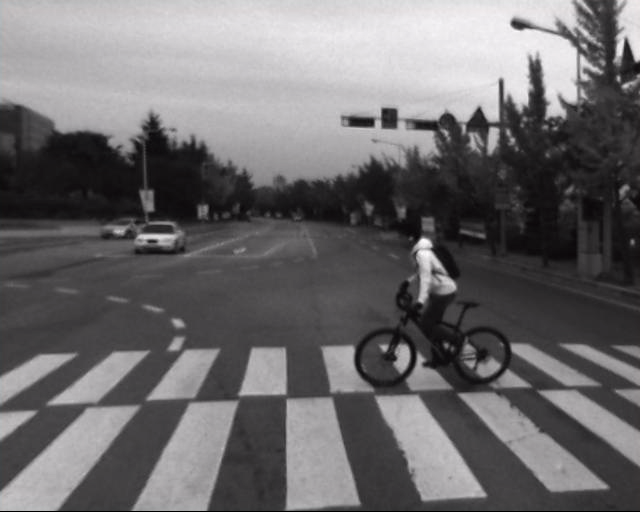

FileNotFoundError: ignored

In [ ]:
#Make predictions on validation images
from IPython.display import Image, display
from keras.preprocessing.image import array_to_img
# Change to '/data/images/Test/' to use all the 500 test images
color_me = []
#for filename in os.listdir('/content/drive/My Drive/Colab Notebooks/images 4/set01/V005/lwir/images/val/class/'):

color_me.append(img_to_array(load_img('/content/drive/My Drive/Colab Notebooks/images 4/set01/V005/visible/images/train/class/I00098.jpg')))
#color_me = np.asarray(Image(filename='/content/drive/My Drive/Colab Notebooks/images 4/set01/V005/lwir/images/val/class/I00005.jpg'),)
color_me = np.array(color_me, dtype=float)
color_me = 1.0/255*color_me
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

# Test model
output = model.predict(color_me)
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((512, 640, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    display(array_to_img(lab2rgb(cur)))
    imsave("result/img_"+str(i)+".jpg", lab2rgb(cur))
